In [29]:
import pandas as pd
df = pd.read_csv("procesos/productos_preguntas_completado.csv",delimiter=",")
df.head()

,CHUNK_PRODUCTO,PREGUNTA,ES_ABIERTA,RESPUESTA
0,sikaflex 221 blanco x 600 ml de la marca sika ...,¿Qué beneficios ofrece el producto sikaflex 22...,1,El producto sikaflex 221 blanco x 600 ml de la...
1,maceta cuadr piedra 30x30x30cm con sist. riego...,¿Por qué elegir el producto maceta cuadr piedr...,1,El producto maceta cuadr piedra 30x30x30cm con...
2,cuchilla plastica econo de la marca home tools...,¿Se puede usar el producto cuchilla plastica e...,0,"Sí, en la mayoría de los casos."
3,coladera redonda abs con rejilla cromada abs d...,¿Qué características destacan del producto col...,1,El producto coladera redonda abs con rejilla c...
4,guirnalda de pompones blancos 1.8m c.natural d...,¿Se puede usar el producto guirnalda de pompon...,0,Depende del modelo.


In [34]:
df_train = df.iloc[:400]
df_test  = df.iloc[400:]

In [35]:
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
import random

# Preparar datos para entrenamiento
train_data = []
for _, row in df_train.iterrows():
    texto = row["PREGUNTA"]
    es_abierto = row["ES_ABIERTA"]
    labels = {
        "cats": {
            "abierta": float(es_abierto == 1),
            "cerrada": float(es_abierto == 0)
        }
    }
    train_data.append((texto, labels))

# Crear modelo en blanco (sin necesidad de conexión)
#nlp = spacy.blank("es")
nlp = spacy.load("es_core_news_sm", disable=["lemmatizer"])
textcat = nlp.add_pipe("textcat")
textcat.add_label("abierta")
textcat.add_label("cerrada")

# Entrenar el modelo
optimizer = nlp.initialize()
for i in range(50): #Numero de iteracciones
    random.shuffle(train_data)
    losses = {}
    batches = minibatch(train_data, size=compounding(4.0, 16.0, 1.001))
    for batch in batches:
        examples = [Example.from_dict(nlp.make_doc(text), labels) for text, labels in batch]
        nlp.update(examples, sgd=optimizer, losses=losses)
    print(f"Iteración {i+1}, pérdida: {losses['textcat']:.4f}")

# Guardar el modelo
nlp.to_disk("modelos/spacy_abierto_cerrado")

Iteración 1, pérdida: 2.3446
Iteración 2, pérdida: 0.0000
Iteración 3, pérdida: 0.0000
Iteración 4, pérdida: 0.0000
Iteración 5, pérdida: 0.0000
Iteración 6, pérdida: 0.0000
Iteración 7, pérdida: 0.0000
Iteración 8, pérdida: 0.0000
Iteración 9, pérdida: 0.0000
Iteración 10, pérdida: 0.0000
Iteración 11, pérdida: 0.0000
Iteración 12, pérdida: 0.0000
Iteración 13, pérdida: 0.0000
Iteración 14, pérdida: 0.0000
Iteración 15, pérdida: 0.0000
Iteración 16, pérdida: 0.0000
Iteración 17, pérdida: 0.0000
Iteración 18, pérdida: 0.0000
Iteración 19, pérdida: 0.0000
Iteración 20, pérdida: 0.0000
Iteración 21, pérdida: 0.0000
Iteración 22, pérdida: 0.0000
Iteración 23, pérdida: 0.0000
Iteración 24, pérdida: 0.0000
Iteración 25, pérdida: 0.0000
Iteración 26, pérdida: 0.0000
Iteración 27, pérdida: 0.0000
Iteración 28, pérdida: 0.0000
Iteración 29, pérdida: 0.0000
Iteración 30, pérdida: 0.0000
Iteración 31, pérdida: 0.0000
Iteración 32, pérdida: 0.0000
Iteración 33, pérdida: 0.0000
Iteración 34, pérdi

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/pipeline/attributeruler.py:137: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)



--- Reporte de clasificación ---
              precision    recall  f1-score   support

     abierta       1.00      1.00      1.00        49
     cerrada       1.00      1.00      1.00        51

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



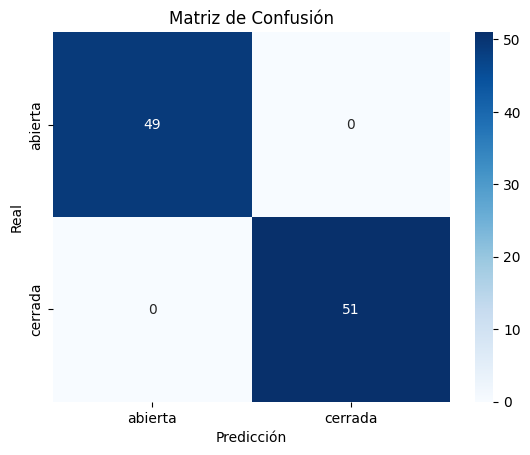

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# 🔹 Evaluación en test
y_true = []
y_pred = []

for _, row in df_test.iterrows():
    texto = row["PREGUNTA"]
    verdadero = row["ES_ABIERTA"]  # 1=abierta, 0=cerrada
    doc = nlp(texto)
    pred_label = "abierta" if doc.cats["abierta"] > doc.cats["cerrada"] else "cerrada"
    y_true.append("abierta" if verdadero == 1 else "cerrada")
    y_pred.append(pred_label)

# 🔹 Reporte de métricas
print("\n--- Reporte de clasificación ---")
print(classification_report(y_true, y_pred))

# 🔹 Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=["abierta", "cerrada"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["abierta", "cerrada"],
            yticklabels=["abierta", "cerrada"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [38]:
import spacy
nlp = spacy.load("modelos/spacy_abierto_cerrado")
# Clasificar nueva pregunta
def clasificar_pregunta(texto):
    doc = nlp(texto)
    scores = doc.cats
    pred = max(scores, key=scores.get)
    return pred, scores

In [39]:
ejemplo = "¿Venden comida en promart?"
etiqueta, scores = clasificar_pregunta(ejemplo)
print(f"\nPregunta: {ejemplo}\nClasificación: {etiqueta}\nScores: {scores}")


Pregunta: ¿Venden comida en promart?
Clasificación: cerrada
Scores: {'abierta': 2.173633583879564e-05, 'cerrada': 0.9999783039093018}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/spacy/pipeline/attributeruler.py:137: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [40]:
def esAbierta(texto):
    doc = nlp(texto)
    scores = doc.cats
    pred = max(scores, key=scores.get)
    return pred!='cerrada'

In [43]:
esAbierta('¿Se puede usar una cocina en el agua?')

False

# Selector de chunks

In [1]:
import spacy
#from spacy.pipeline import EntityRuler

# Cargar modelo de spaCy
nlp = spacy.blank("es")  # Usamos un modelo vacío en español

# Crear una regla por cada entidad
ruler = nlp.add_pipe("entity_ruler")

# Generar patrones desde listas
patterns = []

for marca in marcas:
    patterns.append({"label": "MARCA", "pattern": marca})

for modelo in modeloss:
    patterns.append({"label": "MODELO", "pattern": modelo})

for anio in ['2014','2015','2016','2017','2018','2019','2020','2021','2022','2023','2024','2025']:
    patterns.append({"label": "AÑO", "pattern": anio})


# Cargar reglas al EntityRuler
ruler.add_patterns(patterns)

# Texto de prueba
texto = """
Necesito una bateria para un mi audi modelo Q5 del año 2025.
Tambien uno para el mi carro modelo GRAND PLUS de BAIC MOTOR del 2014
"""

# Procesar texto
doc = nlp(texto.upper())

# Mostrar entidades detectadas
for ent in doc.ents:
    print(f"{ent.text} → {ent.label_}")

NameError: name 'marcas' is not defined

In [2]:
import spacy
from spacy.matcher import Matcher

# Carga modelo base (español)
nlp = spacy.load("es_core_news_sm")

In [25]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

# -----------------------
# Patrones de consulta general de producto
producto_patterns = [
    [{"LOWER": {"IN": ["tienen", "hay", "venden", "disponible"]}}, {"POS": "NOUN"}],
    [{"LOWER": "busco"}, {"POS": "DET", "OP": "?"}, {"POS": "NOUN"}],
    [{"LOWER": {"IN": ["necesito", "quisiera"]}}, {"POS": "DET", "OP": "?"}, {"POS": "NOUN"}],
    [{"LOWER": {"IN": ["tienen", "hay"]}}, {"LOWER": {"IN": ["descuento", "promocion", "oferta"]}}],
    [{"LOWER": "este"}, {"LOWER": "producto"}, {"LOWER": "en"}, {"LOWER": {"IN": ["oferta", "descuento"]}}],
    [{"LOWER": "está"}, {"LOWER": "en"}, {"LOWER": {"IN": ["oferta", "promocion", "rebaja"]}}],
    [{"LOWER": "precio"}, {"LOWER": "rebajado"}]
]

# Patrones de ficha técnica
ficha_patterns = [
    [{"LOWER": {"IN": ["peso", "material", "garantia", "dimensiones", "voltaje", "capacidad", "watts"]}}],
    [{"LOWER": {"IN": ["es"]}}, {"LOWER": {"IN": ["resistente", "impermeable", "inoxidable"]}}],
    [{"LOWER": "de"}, {"LOWER": "que"}, {"LOWER": "material"}, {"LOWER": "es"}]
]

descripcion_patterns = [
    [{"LOWER": "que"}, {"LOWER": "es"}],
    [{"LOWER": "para"}, {"LOWER": "que"}, {"LOWER": "sirve"}],
    [{"LOWER": "cual"}, {"LOWER": "es"}, {"LOWER": "su"}, {"LOWER": "funcion"}],
    [{"LOWER": "como"}, {"LOWER": "funciona"}],
    [{"LOWER": "que"}, {"LOWER": "hace"}],
    [{"LOWER": {"IN": ["describe", "describirme", "puedes", "podrías"]}}, {"LOWER": {"IN": ["esto", "este", "producto", "articulo", "objeto"]}}],
    [{"LOWER": "que"}, {"LOWER": "características"}, {"LOWER": "tiene"}],
]

recomendacion_patterns = [
    [{"LOWER": "que"}, {"LOWER": "me"}, {"LEMMA": "recomendar"}],
    [{"LOWER": "cual"}, {"LOWER": "me"}, {"LEMMA": "recomendar"}],
    [{"LOWER": "que"}, {"LOWER": "me"}, {"LEMMA": "sugerir"}],
    [{"LOWER": "cual"}, {"LOWER": "es"}, {"LOWER": {"IN": ["mejor", "más", "mas"]}}, {"OP": "*"}],
    [{"LOWER": "que"}, {"LEMMA": "convenir"}, {"OP": "*"}],
    [{"LEMMA": {"IN": ["poder", "recomendar"]}}, {"LOWER": {"IN": ["una", "un", "algo"]}, "OP": "?"}]
]


# Agregar múltiples categorías al mismo matcher
matcher.add("CONSULTA_PRODUCTO", producto_patterns)
matcher.add("FICHA_TECNICA", ficha_patterns)
matcher.add("DESCRIPCION", descripcion_patterns)
matcher.add("RECOMENDACION", recomendacion_patterns)

# -----------------------
# Clasificador de frases según categoría detectada

def clasificar_consulta(texto):
    doc = nlp(texto)
    matches = matcher(doc)
    etiquetas_detectadas = set()
    for match_id, start, end in matches:
        etiqueta = nlp.vocab.strings[match_id]
        etiquetas_detectadas.add(etiqueta)
    return list(etiquetas_detectadas) if etiquetas_detectadas else ["NINGUNA"]

# -----------------------
# Pruebas

ejemplos = [
    "¿Tienen sillas plegables?",
    "Busco una lámpara de escritorio.",
    "¿Cual es el peso del taladro?",
    "¿Es resistente al agua?",
    "¿Tienen este producto en descuento?",
    "¿que voltaje tiene el microondas?",
    "Para que sirve una cocina?",
    "venden camas?",
    "que cama me recomiendan?"
]

for frase in ejemplos:
    categorias = clasificar_consulta(frase)
    print(f"{frase} → {categorias}")


¿Tienen sillas plegables? → ['CONSULTA_PRODUCTO']
Busco una lámpara de escritorio. → ['CONSULTA_PRODUCTO']
¿Cual es el peso del taladro? → ['FICHA_TECNICA']
¿Es resistente al agua? → ['FICHA_TECNICA']
¿Tienen este producto en descuento? → ['CONSULTA_PRODUCTO']
¿que voltaje tiene el microondas? → ['FICHA_TECNICA']
Para que sirve una cocina? → ['DESCRIPCION']
venden camas? → ['CONSULTA_PRODUCTO']
que cama me recomiendan? → ['RECOMENDACION']


In [27]:
clasificar_consulta('que caracteristicas tiene la cama')

['NINGUNA']